In [54]:
%reload_ext autoreload
%autoreload 2

import missingno as msno
import numpy as np
import os
import pandas as pd
import plotly.express as px
import seaborn as sns
import sys

from loguru import logger
from matplotlib import pyplot as plt
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from settings.params import *
from src.utils import configure_logger

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
configure_logger()

In [55]:
data = pd.read_csv(RAW_DATA)
TARGET_NAME = MODEL_PARAMS['TARGET_NAME']

# Exploratory Data Analysis


## Missing values


<Axes: >

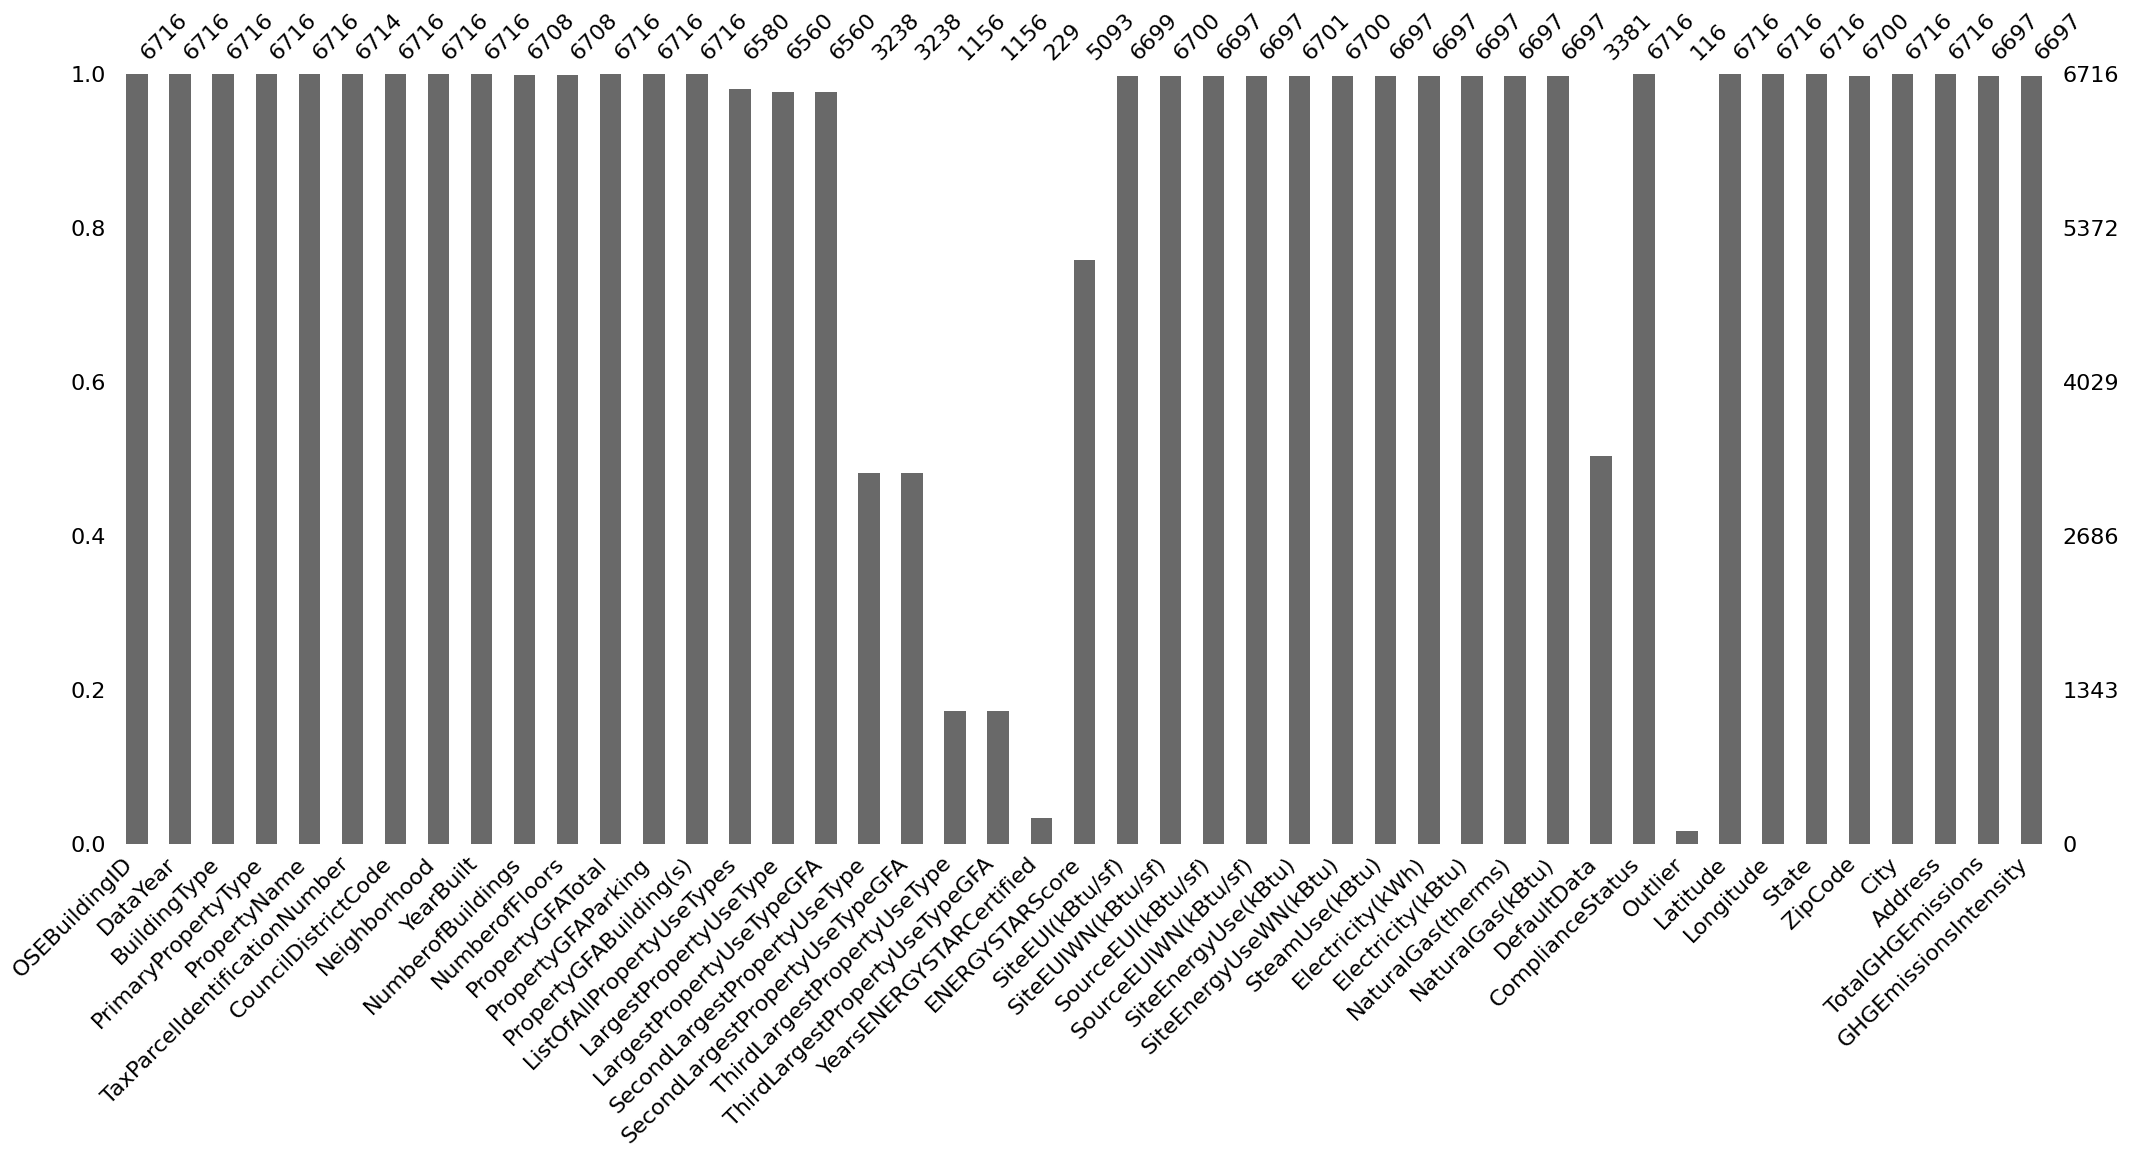

In [56]:
msno.bar(data)

In [57]:
logger.info(f"Number of null values per column: {data.isna().sum()}")

2024-08-08 09:45:14.007 | INFO     | __main__:<module>:1 - Number of null values per column: OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
TaxParcelIdentificationNumber         2
CouncilDistrictCode                   0
Neighborhood                          0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        8
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes           136
LargestPropertyUseType              156
LargestPropertyUseTypeGFA           156
SecondLargestPropertyUseType       3478
SecondLargestPropertyUseTypeGFA    3478
ThirdLargestPropertyUseType        5560
ThirdLargestPropertyUseTypeGFA     5560
YearsENERGYSTARCertified           6487
ENERGYSTARScore            

In [58]:
data['ComplianceStatus'].value_counts()

Compliant                       6548
Error - Correct Default Data     113
Non-Compliant                     40
Missing Data                      15
Name: ComplianceStatus, dtype: int64

After reading the descriptions of each of the columns present in the dataset, we can make the following observations about some notable missing data:

- SecondLargestPropertyUseType & ThirdLargestPropertyUseType contain lots of missing values. When they are absent we can interpret that as the corresponding building not having a second or third use type.
- Outlier is a column which indicates if the building's measures correspond to a high or low outlier(true outliers in summary). We interpret the absence of value as indicating that the building is supposedly normal.
- YearsEnergyStarCertified is a list of years for which the building has been certified EnergyStar. Nan values mean that the building has never had the certification.
- Comments is a column which should contain comments by a building owner or an agent to provide context about the building's energy use. No comments were made in the dataset. We can already drop that column from our dataset.


## Target Analysis


In [59]:
data[TARGET_NAME].describe()

count    6.701000e+03
mean     5.194673e+06
std      1.813648e+07
min      0.000000e+00
25%      9.200689e+05
50%      1.791071e+06
75%      4.135280e+06
max      8.739237e+08
Name: SiteEnergyUse(kBtu), dtype: float64

/Users/pamoussa/anaconda3/envs/mlops/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log



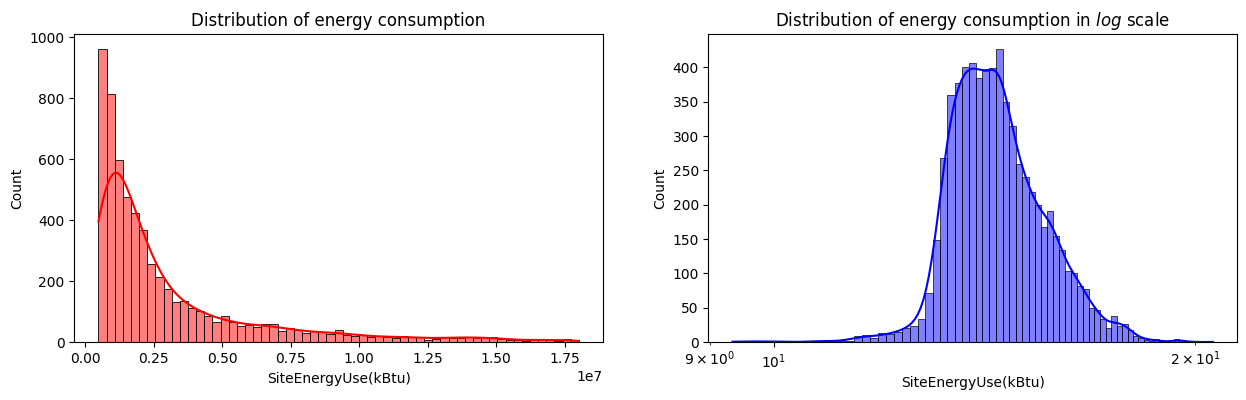

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# 5th percentile of target
lower_percentile = data[TARGET_NAME].quantile(0.05)

# 95th percentile of target
upper_percentile = data[TARGET_NAME].quantile(0.95)

sns.histplot(data[(data[TARGET_NAME] >= lower_percentile) & (data[TARGET_NAME] <= upper_percentile)][TARGET_NAME], color='r', kde=True, ax=axes[0])
axes[0].set_title('Distribution of energy consumption')

sns.histplot(np.log(data[TARGET_NAME]), color='b', kde=True, ax=axes[1])
axes[1].set_title('Distribution of energy consumption in $log$ scale')
axes[1].set_xscale('log')

- Some of the buildings investigated have zero energy use which does not make sense in this context. An analysis on the compliance of some of the data shows that almost all of those buildings' data are marked as non-compliant, missing or Default Data in the dataset. That means we cannot take that data into account.
- The distribution of the target variable is highly skewed. Converting it to a log scale allows for a normal distribution, which can be more easily exploited by the model to be built.


In [61]:
# Compliance of the rows for which SiteEnergyUse is zero
data[data[TARGET_NAME] == 0]['ComplianceStatus']

44                         Compliant
572                        Compliant
3368                    Missing Data
3371                    Missing Data
3402                    Missing Data
3421                    Missing Data
3425                    Missing Data
3435                    Missing Data
3473                    Missing Data
3479                    Missing Data
3492                    Missing Data
3644                   Non-Compliant
3954                    Missing Data
3970                    Missing Data
4086                    Missing Data
4100                    Missing Data
4701    Error - Correct Default Data
4889                   Non-Compliant
5234                    Missing Data
6506                    Missing Data
Name: ComplianceStatus, dtype: object

In [62]:
fig = px.box(data, y="SiteEnergyUse(kBtu)")
fig.show()

The box plot illustrates the distribution of SiteEnergyUse(kBtu). The majority of the data points cluster near the lower end of the energy use spectrum, indicating relatively low energy consumption for most entries. However, there are several prominent outliers that deviate significantly from this cluster:

- There are a few data points that exhibit exceptionally high energy use, with values reaching up to 800 million kBtu.
- These high outliers are considerably distant from the main cluster, indicating that certain sites have much higher energy consumption compared to the rest.
- The presence of these outliers suggests variability in the dataset, which could be due to differences in site size, operational hours, or inefficiencies.
- These outliers need to be further investigated to understand the underlying causes and to determine if they should be included in the analysis or addressed separately. That analysis will be done when cleaning the data and we will use the Outlier column available in the dataset to determine which ones are true outliers and which ones are incoherent values.


## Data Analysis


### Numerical Features


In [63]:
numerical_features = data.select_dtypes(include="number").columns
numerical_data = data[numerical_features]
logger.info(f"Categorical features:\n {sorted(numerical_features)}\n")

2024-08-08 09:45:16.018 | INFO     | __main__:<module>:3 - Categorical features:
 ['CouncilDistrictCode', 'DataYear', 'ENERGYSTARScore', 'Electricity(kBtu)', 'Electricity(kWh)', 'GHGEmissionsIntensity', 'LargestPropertyUseTypeGFA', 'Latitude', 'Longitude', 'NaturalGas(kBtu)', 'NaturalGas(therms)', 'NumberofBuildings', 'NumberofFloors', 'OSEBuildingID', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'PropertyGFATotal', 'SecondLargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SteamUse(kBtu)', 'ThirdLargestPropertyUseTypeGFA', 'TotalGHGEmissions', 'YearBuilt', 'ZipCode']



In [64]:
numerical_data.head()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Latitude,Longitude,ZipCode,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2015,7,1927,1.0,12.0,88434,0,88434,88434.0,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,47.612190,-122.337997,98101.0,249.43,2.64
1,2,2015,7,1996,1.0,11.0,103566,15064,88502,83880.0,15064.0,4622.0,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,47.613106,-122.333358,98101.0,263.51,2.38
2,3,2015,7,1969,1.0,41.0,961990,0,961990,757243.0,100000.0,0.0,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,47.613349,-122.337699,98101.0,2061.48,1.92
3,5,2015,7,1926,1.0,10.0,61320,0,61320,61320.0,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,47.614216,-122.336609,98101.0,1936.34,31.38
4,8,2015,7,1980,1.0,18.0,119890,12460,107430,123445.0,68009.0,0.0,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,47.613754,-122.340924,98121.0,507.70,4.02


#### Data distributions


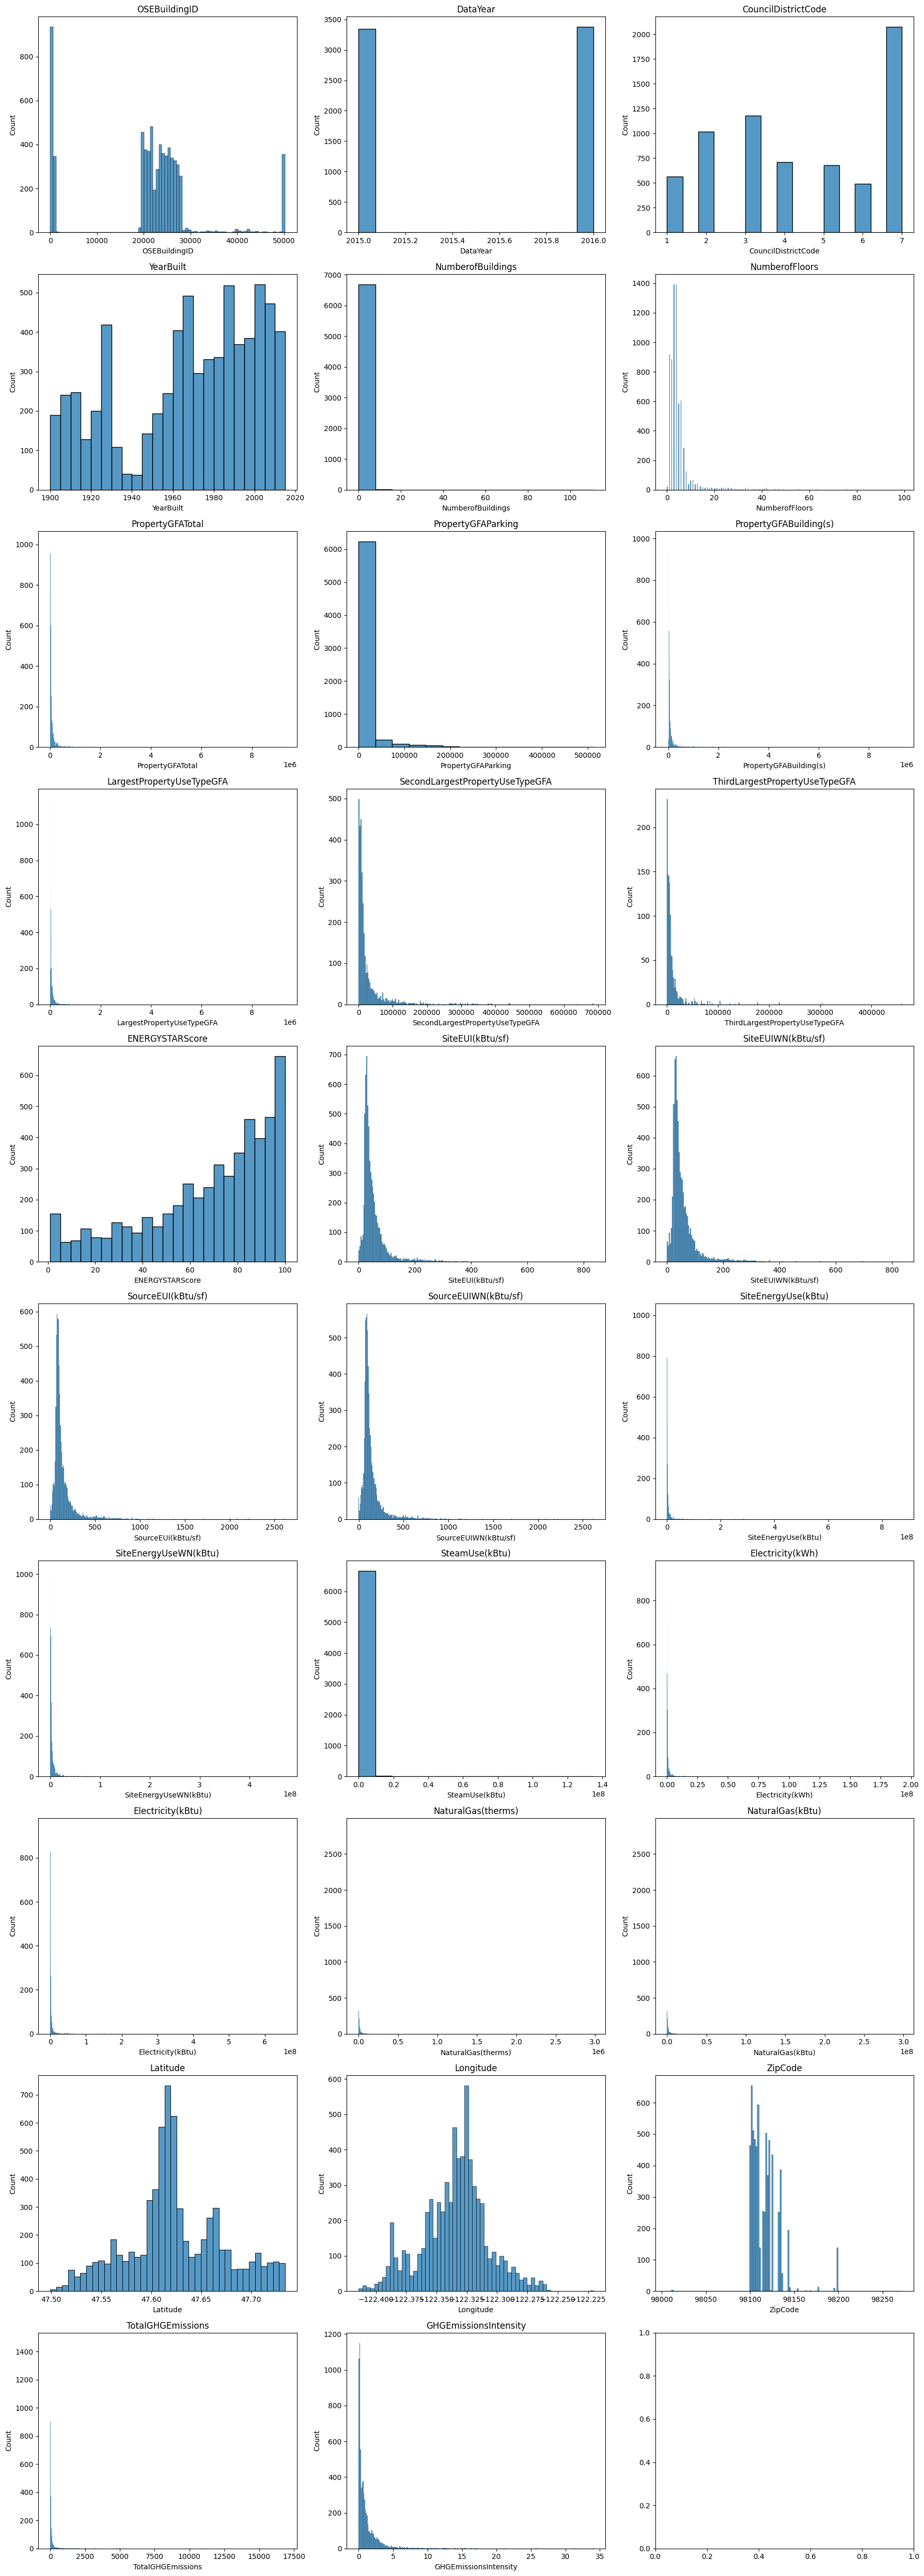

In [52]:
num_cols = 3
num_rows = (len(numerical_features) + num_cols - 1) // num_cols  # calculate the number of rows needed
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*6, num_rows*5))  # adjust figsize as needed

for i, col in enumerate(numerical_features):
    row = i // num_cols
    col_pos = i % num_cols
    sns.histplot(numerical_data[col], kde=False, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(col)

plt.tight_layout()
plt.show()

#### Scatter Plots


In order to have meaningful visualizations, we need to limit the data to building's whose energy use is between the 5th and 95th percentiles.


In [53]:
limited_numerical_data = data[(data[TARGET_NAME] >= lower_percentile) & (data[TARGET_NAME] <= upper_percentile)]

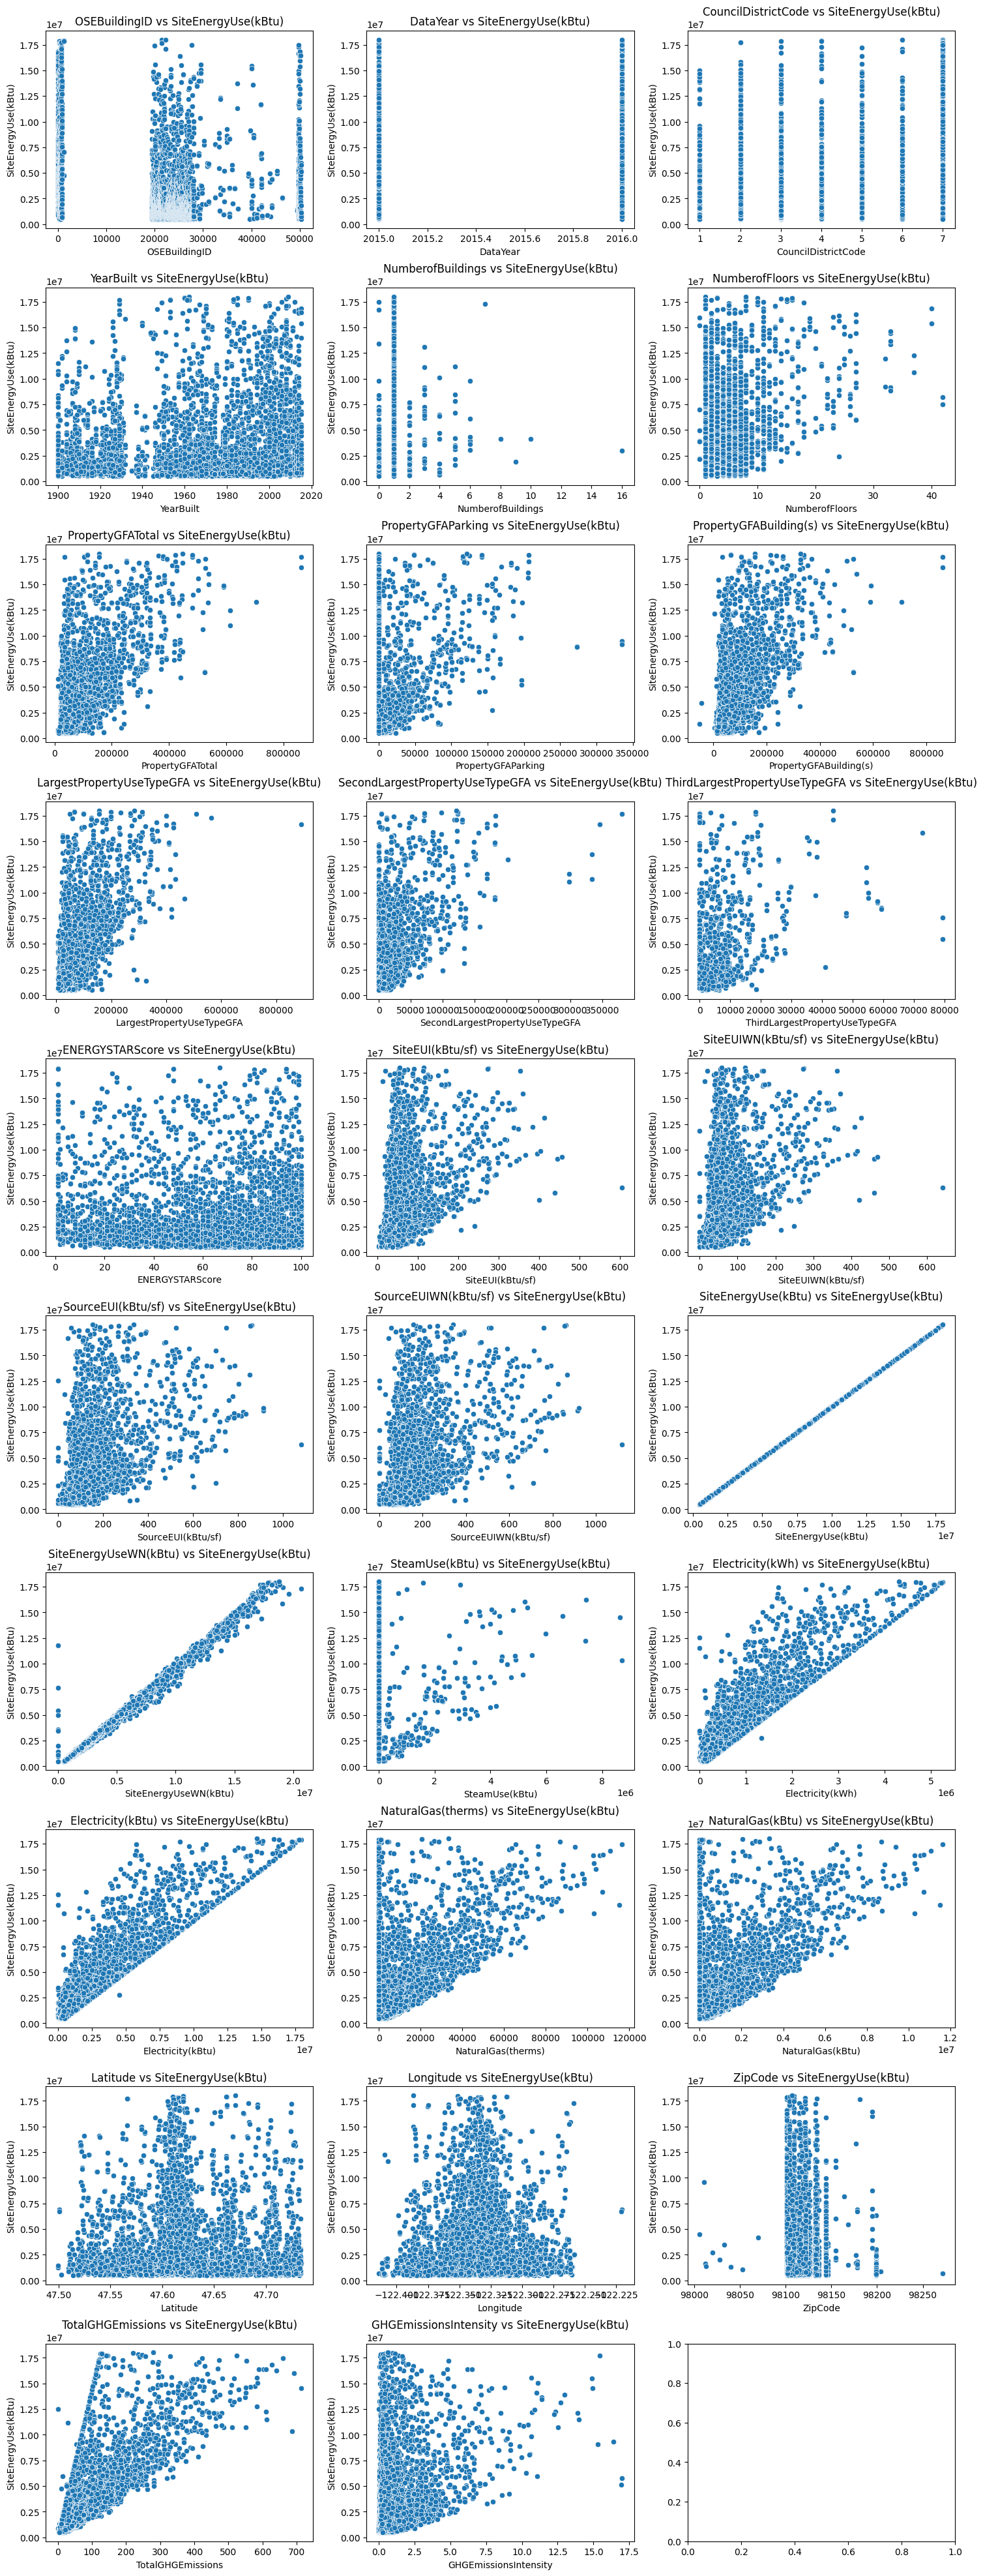

In [65]:
# Number of plots per row
plots_per_row = 3

# Calculate number of rows needed
num_rows = len(numerical_features) // plots_per_row + (len(numerical_features) % plots_per_row > 0)

# Create subplots
fig, axs = plt.subplots(num_rows, plots_per_row, figsize=(6 * plots_per_row, 5 * num_rows))

# Flatten axs for easy iteration
axs = axs.flatten()

# Plot each numerical column against the target variable
for i, column in enumerate(numerical_features):
    sns.scatterplot(x=limited_numerical_data[column], y=limited_numerical_data[TARGET_NAME], ax=axs[i])
    axs[i].set_title(f'{column} vs {TARGET_NAME}')

fig.subplots_adjust(hspace=0.3, wspace=0.2)

#### Correlation Matrix


In [ ]:
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

#### Observations:

- All values related to energy are highly correlated to the target column SiteEnergyUse(kbtu). All those columns correspond to data that is obtained with the energy consumption statement. They can cause data leakage when used as features for the model

- The column NumberOfBuildings has some zeros. For this column the value should be at least 1

- The column NumberOfFloors also has zeros where its minimum value should be 1

- The column NumberOfFloors

- Some properties can already be classified as being unhelpful to the future model since they do not provide any relevant or quantifiable information about the building in itself: OSEBuildingID, DataYear, ZipCode, CouncilDistrictCode

- Instead of using directly YearBuilt, we are going to transform it into an Age column to simplify its relationship to the target variable and avoid data leakage.

- Since the site energy use is known, there is no need for having an absolute value for the consumption of Electricity, Steam or Gas. We are going to replace the corresponding columns with the ratio of the consumption of those types of energy on the total energy use.

- In the same way, instead of using absolute values for the largest use types GPAs, we can use the ratios on the total GPA.


### Categorical Features


In [ ]:
categorical_features = data.select_dtypes(include=["object", "bool"]).columns
categorical_data = data[categorical_features]
categorical_data[TARGET_NAME] = data[TARGET_NAME]
logger.info(f"Categorical features:\n {sorted(categorical_features)}\n")

In [ ]:
categorical_data.loc[:, categorical_features].describe()

In [ ]:
categorical_data.loc[:, categorical_features].info()

#### Box plots


Before creating the box plots, some features can already be filtered out since they obviously do not provide any information relevant to energy use and they would make the visualization more difficult to analyze


In [ ]:
categorical_features = list(filter(lambda x: x not in ["TaxParcelIdentificationNumber", "PropertyName", "Address", "City", "State", "ListOfAllPropertyUseTypes"], categorical_features))

In [ ]:
categorical_features

In the same manner as before, we are going to limit the data in order to have meaningful visualizations


In [ ]:
len(set(data['LargestPropertyUseType'].unique()) - set(data['PrimaryPropertyType'].unique()))

In [ ]:
data['PrimaryPropertyType'].unique()

In [ ]:
data['LargestPropertyUseType'].unique()

In [ ]:
limited_categorical_data = categorical_data[(categorical_data[TARGET_NAME] >= lower_percentile) & (categorical_data[TARGET_NAME] <= upper_percentile)]

# Plot each categorical column against the target variable
for i, column in enumerate(categorical_features):
    fig = px.box(data_frame=limited_categorical_data, x=column, y=TARGET_NAME, title=f'{column} by {TARGET_NAME}')
    fig.show()

#### Observations

- PrimaryPropertyType column contains data redundant to what's in LargestPropertyUseType. We will work only with the second one which contains a lot more classes. That could help the model make better choices.
- The columns BuildingType, PrimaryPropertyType and the ones concerning the property use types seem to have an effect on the target column.
- Some columns can already be classified as not providing valuable information for our problem: TaxParcelIdentificationNumber, PropertyName, Address, City and State
- DefaultData, Outlier and ComplianceStatus do not really provide information that could be relevant to knowing the energy usage of a site. They will mostly help in order ot understand better the data at hand and clean it accordingly
- ListOfAllPropertyUseTypes contains data that will be mostly redundant to what we have in LargestPropertyUseType, SecondLargestPropertyUseType and ThirdLargestPropertyUseType. There are very few buildings that have up to a third use, so we suppose that buildings that have 4 or more uses are even more rare. Since this column contains information redundant to other columns and does not provide more information than we have, we will not use it for our model.
- YearsEnergyStarCertified cannot be used since it will cause data leakage. That information may not be known at the time of prediction.
